## import libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
from scipy.stats import zscore

In [2]:
#make plot interactive
plt.ion()

# 1)  Social Indicator

### Load & clean data 

In [3]:
# load the necessary data here 
admin = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Stadtteile_Hamburg.shp")
stats = pd.read_csv("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/statistics_HH21.csv",encoding="utf-8", delimiter=";",decimal="." )
#admin
#print(stats.head())

In [4]:
#rename columns
stats.columns = ['district','inhabitants', 'pop<18','%<18', 'pop>65y','%>65', 'foreignResidents', 'migration_backg', 'hh','pp_size','hh_kids', '%hh_kids','areakm2', 'pop_density','working_pop', '%working_pop', 'unemployed','%unemployed','unemployed<18','%unemployed<18', 'unemployed>65', '%unemployed>65','social_benefits', '%social_benefits','social_housing', '%social_housing']
#stats


In [5]:
#joined population data with shapefile of admin boundaries and dropped additional columns in the admin dataset
admin_pop = pd.merge(admin,stats, left_on='stadtteil_', right_on='district', how = 'inner')

admin_pop.drop(columns=['OBJECTID','bezirk', 'stadttei_1', 'stadttei_2','pp_size', '%<18', 'hh','foreignResidents', 'migration_backg','pop<18','hh_kids', '%hh_kids', 'pop>65y', 'unemployed<18', ],axis=1, inplace=True)

#admin_pop
#fig, ax = plt.subplots(figsize=(24, 18))
#admin_pop.plot(ax=ax, alpha=1,linewidth=2, facecolor="none")

In [6]:
# checks the number of null values and drops the null values in the colums used for calculation of social status
admin_pop.isnull().mean() * 100
admin_pop.dropna(subset=['%unemployed','%social_benefits','%social_housing','%unemployed>65' ], inplace=True)

#admin_pop.dropna(inplace=True)
#admin_pop.plot()
admin_pop.head()

,bezirk_nam,stadtteil_,SHAPE_Leng,SHAPE_Area,geometry,district,inhabitants,%>65,areakm2,pop_density,...,%working_pop,unemployed,%unemployed,%unemployed<18,unemployed>65,%unemployed>65,social_benefits,%social_benefits,social_housing,%social_housing
0,Hamburg-Mitte,Hamburg-Altstadt,9028.180532,3.676562e+06,"POLYGON ((1113865.821 7085107.333, 1113978.324...",Hamburg-Altstadt,2358,10.9,1.3,1.813.00,...,67.6,98,5.3,NaN,14,5.7,193,8.2,176,12.4
1,Hamburg-Mitte,HafenCity,13902.691334,6.860720e+06,"POLYGON ((1113043.882 7082944.386, 1112901.932...",HafenCity,6302,9.5,2.4,2.598.00,...,61.1,144,3.1,NaN,14,2.7,309,4.9,799,24.9
2,Hamburg-Mitte,Neustadt,11133.923114,6.395226e+06,"POLYGON ((1112508.476 7085835.161, 1112319.283...",Neustadt,12611,15.0,2.3,5.575.00,...,64.0,494,5.2,2.9,104,6.5,911,7.2,967,12.6
3,Hamburg-Mitte,St. Pauli,15968.675123,6.343533e+06,"POLYGON ((1109116.549 7084327.397, 1109001.027...",St. Pauli,21803,10.3,2.2,9.723.00,...,57.0,1.330.00,7.8,3.4,282,10.7,2.708.00,12.4,1.485.00,11.7
4,Hamburg-Mitte,St. Georg,9795.650670,5.155061e+06,"POLYGON ((1114563.830 7085359.663, 1114541.839...",St. Georg,11467,14.0,1.8,6.291.00,...,60.1,489,5.5,2.8,103,7.0,841,7.3,852,13.2


%unemployed          2.429636
%social_benefits     6.941654
%social_housing     10.981457
%unemployed>65       2.461121
dtype: float64

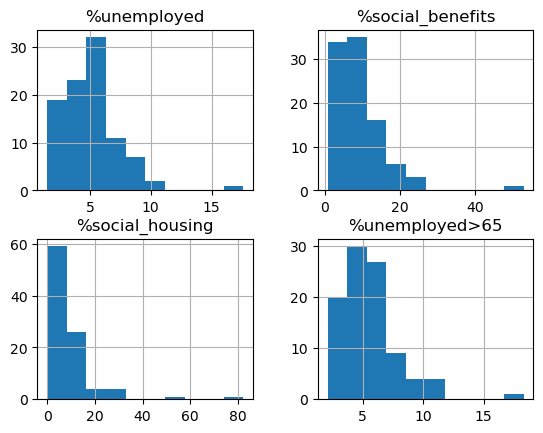

In [7]:
# this line of code first subsets the dataframe so that only numeric columns relevant to the further anylsis (social status) are maintained
# code than checks standard deviation 
social_stats = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65' ]]#std()

social_stats.hist()
social_stats.std()

In [8]:
# The scipy Library in Python is used to calculate the z-score which helps to standardize the values for each column 

z_scores_admin_pop = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65']].apply(zscore)

print(z_scores_admin_pop.std())

%unemployed         1.005305
%social_benefits    1.005305
%social_housing     1.005305
%unemployed>65      1.005305
dtype: float64


In [9]:
#z_scores_admin_pop

### Analysis

In [10]:
#groups / classifies the results into equal percentiles of the respective column (equal quantiles 0 -4 (e.g. 0= lowest 20th quantile of mean / to  - 4 within highest 20th quantile))
#and saves the results to a new column. all the 4 indicators are equally weighted. no difference has been made
z_scores_admin_pop['qt_soc_stats'] = pd.qcut(z_scores_admin_pop['%unemployed'] + z_scores_admin_pop['%social_benefits'] + z_scores_admin_pop['%social_housing'] + z_scores_admin_pop['%unemployed>65'], 5, labels=[0, 1, 2, 3, 4])


In [11]:
#function to add a text column to the data frame based on the classification into percentiles (will be applied to the  different indicators)
def add_status_column(df, zscore_mean_column):
    df['status'] = ['very low' if x == 0 else  #creates the new column "status and then adds text description to the corresponding value"
                   'low' if x == 1 else
                   'medium' if x == 2 else
                   'high' if x == 3 else
                   'very high' for x in df[zscore_mean_column]]
    
add_status_column(z_scores_admin_pop, 'qt_soc_stats')


In [12]:
#apply function to add status column
add_status_column(z_scores_admin_pop, 'qt_soc_stats')

In [13]:
z_scores_admin_pop.head()

,%unemployed,%social_benefits,%social_housing,%unemployed>65,qt_soc_stats,status
0,0.051394,-0.122718,0.355872,0.042137,3,high
1,-0.858895,-0.600631,1.500193,-1.183286,1,low
2,0.010018,-0.267540,0.374181,0.368917,3,high
3,1.085814,0.485535,0.291790,2.084510,4,very high
4,0.134148,-0.253058,0.429108,0.573154,3,high


In [14]:
#merges the social statistics computed to the admin data frame to be able to plot the data later on
admin_socstats = pd.merge(admin_pop, z_scores_admin_pop, left_index=True, right_index=True)
admin_socstats.head()

,bezirk_nam,stadtteil_,SHAPE_Leng,SHAPE_Area,geometry,district,inhabitants,%>65,areakm2,pop_density,...,social_benefits,%social_benefits_x,social_housing,%social_housing_x,%unemployed_y,%social_benefits_y,%social_housing_y,%unemployed>65_y,qt_soc_stats,status
0,Hamburg-Mitte,Hamburg-Altstadt,9028.180532,3.676562e+06,"POLYGON ((1113865.821 7085107.333, 1113978.324...",Hamburg-Altstadt,2358,10.9,1.3,1.813.00,...,193,8.2,176,12.4,0.051394,-0.122718,0.355872,0.042137,3,high
1,Hamburg-Mitte,HafenCity,13902.691334,6.860720e+06,"POLYGON ((1113043.882 7082944.386, 1112901.932...",HafenCity,6302,9.5,2.4,2.598.00,...,309,4.9,799,24.9,-0.858895,-0.600631,1.500193,-1.183286,1,low
2,Hamburg-Mitte,Neustadt,11133.923114,6.395226e+06,"POLYGON ((1112508.476 7085835.161, 1112319.283...",Neustadt,12611,15.0,2.3,5.575.00,...,911,7.2,967,12.6,0.010018,-0.267540,0.374181,0.368917,3,high
3,Hamburg-Mitte,St. Pauli,15968.675123,6.343533e+06,"POLYGON ((1109116.549 7084327.397, 1109001.027...",St. Pauli,21803,10.3,2.2,9.723.00,...,2.708.00,12.4,1.485.00,11.7,1.085814,0.485535,0.291790,2.084510,4,very high
4,Hamburg-Mitte,St. Georg,9795.650670,5.155061e+06,"POLYGON ((1114563.830 7085359.663, 1114541.839...",St. Georg,11467,14.0,1.8,6.291.00,...,841,7.3,852,13.2,0.134148,-0.253058,0.429108,0.573154,3,high


In [15]:
#save the data frame as csv file
#admin_socstats.to_csv("./output/social_stats.csv")

### VISUALIZATION

<Axes: >

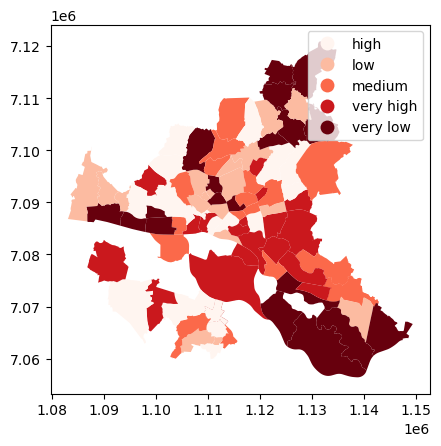

In [16]:
#plot output
admin_socstats.plot("status", cmap="Reds", legend=True)  

# 2) Environmental Indicators
uses noise, green areas, surface temperature? as indicator)

In [ ]:
#load the data
noise = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Laermkarten_HH_2018-11-19.shp")
buildings = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Gebaeude_Hamburg.shp")
green_areas = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Oeffentliche_Gruenanlage_Hamburg.shp")

In [ ]:
# function to checks crs of different layers and reproject to epgs:Hamburg, GE to prepare for joining later on EPSG:25832
def reproject_to_local_epsg(gdf):
    # Checks the CRS of the input GeoDataFrame
    print('Original CRS:', gdf.crs)

    # Reprojects the GeoDataFrame to EPSG 25832
    gdf_reproj = gdf.to_crs(epsg=25832)

    # Prints out the CRS of the output GeoDataFrame
    print('Reprojected CRS:', gdf_reproj.crs)

    return gdf_reproj

# apply function all of data set to convert crs
admin_pop_reproj = reproject_to_local_epsg(admin_pop)
noise_reproj = reproject_to_local_epsg(noise)
housing_reproj = reproject_to_local_epsg(buildings)
green_areas_reproj = reproject_to_local_epsg(green_areas)


## a) Green areas 

In [19]:
#green_areas_reproj.columns

In [ ]:
#for green areas delete the values with code 10 - playground according to ALKIS the official cadastre information system) key and drop some of the unimportant columns
green_areas_reproj = green_areas_reproj[green_areas_reproj.nutzung != 10]

#drop unimportant columns from the dataset
green_areas_reproj.drop(columns=['veroeffent', 'nutzung', 'nutz_code' ,'herrichtun', 'gesamtanla','aktualitae','idnr','belegenh_1','belegenhei','quelle_dat', 'stand'],axis=1, inplace=True)

green_areas_reproj.head()

In [21]:
#green_areas_reproj.plot()

#### Calculation of statistics of green areas at district level

In [ ]:
# Calculates the sum of the area  statistics for the green areas per district (district = stadtteil)
green_area_sum = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].sum().reset_index()
green_area_sum.rename(columns={'flaeche_ha': 'green_area_total_ha'}, inplace=True)

# Calculates mean green space area per district
green_area_mean = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].mean().reset_index()
green_area_mean.rename(columns={'flaeche_ha': 'green_area_mean_ha'}, inplace=True)

# Calculates the count of green spaces per district=  bennenung = unique name of green area
green_space_count = green_areas_reproj.groupby(['stadtteil'])['benennung'].count().reset_index()
green_space_count.rename(columns={'benennung': 'green_space_count'}, inplace=True)

# Combines the statistics into one data frame
green_stats = pd.merge(green_area_sum, green_area_mean, on='stadtteil')
green_stats = pd.merge(green_stats, green_space_count, on='stadtteil')


In [ ]:
# Calculates the percentage of green space from total area of the district
green_stats['perc_green_area'] = green_areas_reproj['flaeche_ha'] / green_areas_reproj['geometry'].area * 100
green_stats.head()

In [ ]:
# Finally calculates the area per inhabitant by using the column inhabitants from the admin_pop_reproj dataframe
# add the column to the green_stats data frame
green_stats = green_stats.merge(admin_pop_reproj[['stadtteil_', 'inhabitants']], left_on='stadtteil', right_on='stadtteil_', how='left')
green_stats.drop('stadtteil_', axis=1, inplace=True)

In [ ]:
#calculate area / inhabitants 
green_stats['area_per_inhbt'] = green_stats['inhabitants'] / green_stats['green_area_total_ha']
green_stats.head()

In [26]:
#check std of relevant values
#green_stats = green_stats[['area_per_inhbt','perc_green_area' ]].std()
#green_stats.std()

In [ ]:
#groups / classifies the results into equal percentiles of the respective column (equal quantiles 0 -4 (e.g. 0= lowest 20th quantile of mean / to  - 4 within highest 20th quantile))
#and saves the results to a new column
green_stats['qt_stats_area_inhbt'] = pd.qcut(green_stats ['area_per_inhbt'],5,labels=[0, 1, 2, 3, 4])


In [29]:
# apply the add column function defined earlier
add_status_column(green_stats, 'qt_stats_area_inhbt')
green_stats.head()

,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,perc_green_area,inhabitants,area_per_inhbt,qt_stats_area_inhbt,status
0,Allermöhe,41.4007,3.450058,7,0.010000,1441.0,34.806175,0,very low
1,Alsterdorf,13.6286,0.592548,6,0.010001,14975.0,1098.792246,3,high
2,Altengamme,0.2130,0.213000,0,0.010002,2319.0,10887.323944,4,very high
3,Altona-Altstadt,28.3002,0.496495,37,0.009993,29151.0,1030.063392,3,high
4,Altona-Nord,8.0044,0.470847,1,0.010012,25942.0,3240.967468,4,very high


In [30]:
#save green stats to csv file


In [ ]:
#merges the green statistics computed to the reprojected admin data frame to be able to plot the data later on
admin_greenstats = pd.merge(admin_pop_reproj, green_stats, left_index=True, right_index=True)
admin_greenstats.head()

### Quick Visualization green areas

In [ ]:
#plot output
admin_greenstats.plot("status", cmap="Greens", legend=True)  

# b) Noise

In [33]:
#for the noise indicator. the assessment aims to identify houses affected by noise and class 

In [34]:
#housing_reproj.columns

In [ ]:
#checks data type of column gebaeudefu which indicates usage of houses (e.g. commercial, resnidential) and than changes it  to integer and drops unimportant columns in the data frame
housing_reproj['gebaeudefu'] = housing_reproj['gebaeudefu'].astype(int)

#print(housing_reproj['gebaeudefu'].dtype)
housing_reproj.drop(columns=['anzahlDerU', 'lageZurErd', 'dachart', 'SHAPE_Leng'],axis=1, inplace=True)


In [ ]:
# filter out any non-residential housing from data set according to ALKIS Key (1000 and 1010 )
housing_reproj = housing_reproj[(housing_reproj['gebaeudefu'] == 1010) | (housing_reproj['gebaeudefu'] == 1000)]#housing_reproj.head()

In [ ]:
###checks out the noise data setwhich is a classified shapefile:  name here stands for severity of noise from 0 low to 4 highest
noise_reproj.head()  

In [ ]:
# the code uses the geopandas overlay method and interesect operation to determine where the noise layer intersects with the house layer to determine the houses affectected by noise
houses_noise = gpd.overlay(housing_reproj, noise_reproj, how='intersection')
#houses_noise.head()

In [ ]:
#renamed columns name to noise class and anzahDerO to english = number of floors
houses_noise = houses_noise.rename(columns={'name': 'noiseclass', 'anzahlDerO': 'floors', 'grundflaec':'house_area'})

In [168]:
# join the data frame to the admin_pop_reproj to be able to plot it later and get affected houses / district
admin_noisestats = gpd.sjoin(admin_pop_reproj, houses_noise)

In [ ]:
#admin_noisestats.columns

In [ ]:
#gets the number of houses per noise class and district
houses_noiseclass = admin_noisestats.groupby(['district', 'noiseclass'])['OBJECTID'].count().reset_index()
houses_noiseclass.head()

In [171]:
# mulitplies the number of houses with the house area 
admin_noisestats['total_area'] = admin_noisestats['OBJECTID'] * admin_noisestats['house_area']

In [191]:
# multiplies the house area with the number of floors to get the total affected residential housing area by noiseclass
admin_noisestats['area_floors']=admin_noisestats['total_area']*admin_noisestats['floors'].astype(int)

In [ ]:
#admin_noisestats['total_area_floors'].hist()
admin_noisestats.head()

In [224]:
# make sure that noise class is an integer
admin_noisestats['noiseclass'] = admin_noisestats['noiseclass'].astype(int)

In [229]:
#weights the areas by noise class in view of severity from low to high 
weights = {0: 1, 1: 1.5, 2: 2, 3: 2.5, 4: 3}
admin_noisestats['weighted_area'] = admin_noisestats['area_floors'] * admin_noisestats['noiseclass'].map(weights) # used the pandas.map function to assign the weights

In [236]:
#groups data set by district and weighted area
#admin_noisestats = admin_noisestats.groupby('district')['weighted_area'].sum().reset_index()
#admin_noisestats['weighted_area'].hist()
#admin_noisestats.head()

,district,weighted_area
0,Allermöhe,8.375514e+09
1,Alsterdorf,7.882582e+11
2,Altengamme,4.693278e+09
3,Altona-Altstadt,3.418078e+11
4,Altona-Nord,4.503477e+11
